# Deep Learning (LSTM) Forecasting
## Objective: Forecast Stock Prices using Long Short-Term Memory (LSTM) Networks.

In [1]:
# ⚠️ AUTO-FIX: Run this cell first to install missing libraries in your current environment
import sys
!{sys.executable} -m pip install tensorflow statsmodels yfinance pandas numpy scikit-learn matplotlib seaborn
print('Libraries installed successfully! You can now run the rest of the notebook.')


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip
Libraries installed successfully! You can now run the rest of the notebook.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

%matplotlib inline

In [3]:
# Load Data
df = pd.read_csv('../data/nifty50_2000_2025_11_30.csv', header=[0, 1], index_col=0, parse_dates=True)
df.columns = [col[0] for col in df.columns]

# Use only Closing Price
data = df.filter(['Close'])
dataset = data.values

# Scaling (LSTM requires 0-1 scale)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

print('Scaled Data Shape:', scaled_data.shape)

Scaled Data Shape: (4465, 1)


In [4]:
# Create Training Data (Last 60 days to predict next day)
training_data_len = int(np.ceil(len(dataset) * .95))

train_data = scaled_data[0:training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape for LSTM [Samples, Time Steps, Features]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print('X_train Shape:', x_train.shape)

X_train Shape: (4182, 60, 1)


In [5]:
# Build LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Train Model
history = model.fit(x_train, y_train, batch_size=1, epochs=1)

4182/4182 ━━━━━━━━━━━━━━━━━━━━ 39s 9ms/step - loss: 6.2739e-04


In [7]:
# Create Test Data
test_data = scaled_data[training_data_len - 60: , :]

x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Predictions
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# RMSE
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print('RMSE:', rmse)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
RMSE: 591.8872854479155


/var/folders/bw/5tc2sfgd3_dg6w_6rv0h5zq80000gn/T/ipykernel_84243/3570042614.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


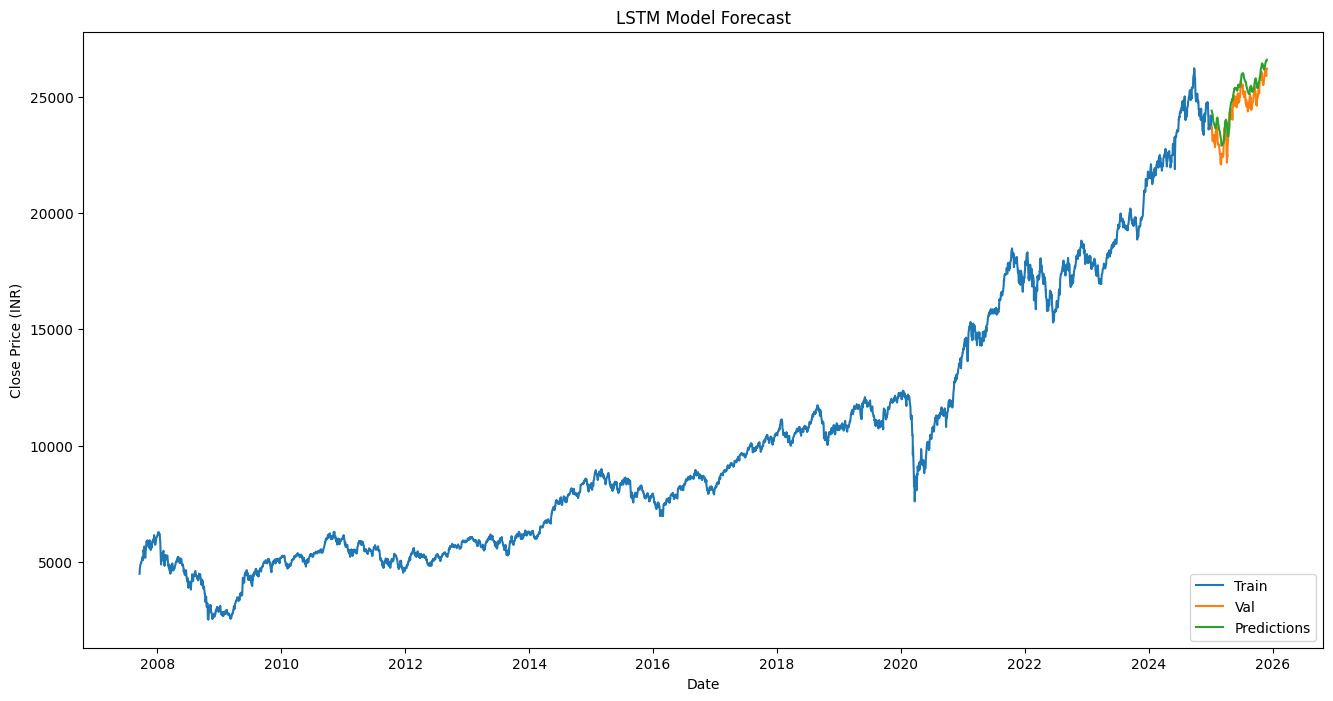

In [8]:
# Visualize Results
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16, 8))
plt.title('LSTM Model Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price (INR)')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()